## Model Definition and Training

In [1]:
import numpy as np
import pandas as pd

import requests
import json
import math
import os

import torch
import torch.optim as optim

from model.classifier import StockClassifier
from model.dataset import StockDataset
from model.estimator import StockClassifierEstimator

from model.benchmark import confusion_matrix
from model.benchmark import binary_measures

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
font = {'weight' : 'normal',
        'size'   : 9}
mpl.rc('font', **font)
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize'] = 'medium'

### Model Definition and Trainer

Our model is defined below and consists of two LSTM networks that process daily/quarterly data, along with a variable number of embeddings for our categorical data. The outputs of these layers are fed through a 4-layer deep linear network. The dimensions of the first layer are specified by the user and are successively halved by the model for the following 3 layers. 

<img src="model.pdf" width=1100px>

In [3]:
!pygmentize model/classifier.py

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data.dataset as dataset
import torch.utils.data.dataloader as dataLoader

from torch.nn.utils.rnn import pad_packed_sequence

import numpy as np
import os

class StockClassifier(nn.Module):
    
    def __init__(self,
                 prediction_interval,
                 data_interval,
                 categorical_features,
                 categorical_features_embedding_dims,
                 daily_features,
                 quarterly_features,
                 embeddings_hidden_dim=10,
                 hidden_dim=100,
                 output_dim=1):
        """ Defines layers of a neural network.

        Args:
            prediction_interval: Interval over which predictions are to be made as datetime.timedelta (encoded in how labels are generated)
            data_interval: Amount of training data as datetime.timedelta (represented in sequence length of features)
            categorical_features:

To facilitate training, a trainer class has been developed as shown below. The class aggregates device, optimizer, and loss function information, and provides a simple validation function to allow piecemeal training of the model.

In [4]:
!pygmentize model/trainer.py

import argparse
import json
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import numpy as np

from scipy.special import expit

class StockClassifierTrainer():

    def __init__(self, model, optimizer, loss_fn, device):
        """ 
            Args:
                model: The PyTorch model that we wish to train.
                optimizer: The optimizer to use during training.
                loss_fn: The loss function used for training. 
                device: Where the model and data should be loaded (gpu or cpu).
        """
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
    
    def train(self, train_loader, epochs, output=True):
        """ 
            Args:
                train_loader: The PyTorch DataLoader that should be used during training.
                epochs: The total number of epochs to train for.
                output: True to print results du

### Model Training
We will create a couple of convenience functions to capture statistics against our test data (i.e., validation) at regular training intervals (i.e., every N epochs as specified by epoch_step below). This will allow us to peform quick hyperparameter tuning on a single fold without training the model on all of our data. The cell below may be executed many times to modify hyperparameters between single-fold training exercises.

In [5]:
def train_and_validate_single_fold(train_ds,test_ds):  
    torch.manual_seed(42)

    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_fn   = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(np.array([0.8])))
    train_dl  = torch.utils.data.DataLoader(train_ds, batch_size=300,shuffle=True,collate_fn = StockDataset.collate_data)
    test_dl   = torch.utils.data.DataLoader(test_ds, batch_size=300,shuffle=True,collate_fn = StockDataset.collate_data)

    model     = StockClassifier(train_ds.get_prediction_interval(),
                                train_ds.get_data_interval(),
                                train_ds.get_categorical_feature_count(),
                                train_ds.get_categorical_feature_embedding_dims(),
                                train_ds.get_daily_feature_count(),
                                train_ds.get_quarterly_feature_count(),
                                embeddings_hidden_dim=10,
                                hidden_dim=500)
  
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    estimator = StockClassifierEstimator(model,optimizer,loss_fn,device)
    
    epoch_count = 0
    epoch_step = 1
    epoch_max = 100

    # Keep track of test and train accuracy, precision and recall after each epoch step
    train_accuracy, train_precision, train_recall = list(), list(), list()
    test_accuracy, test_precision, test_recall = list(), list(), list()
    train_loss = list()

    for i, epochs in enumerate(range(int(epoch_max/epoch_step))):  
        # Train model for some more epochs & evaluate after each step
        loss = estimator.fit(train_dl, epochs=epoch_step, output=False)
        train_loss.append(loss)
        epoch_count += epoch_step

        model.eval()

        y_hat, y = estimator.validate(train_dl)

        c_matrix = confusion_matrix(y_hat,y,output=False)
        a, p, r = binary_measures(c_matrix,output=False)
        train_accuracy.append(a)
        train_precision.append(p)
        train_recall.append(r)   

        print('Epoch: %3s' % f'{epoch_count}/{epoch_max}, Loss: {round(loss,4)}, F1: {round(a,2)}, Precision: {round(p,2)}, Recall: {round(r,2)}')

        y_hat, y = estimator.validate(test_dl)

        c_matrix = confusion_matrix(y_hat,y,output=False)
        a, p, r = binary_measures(c_matrix,output=False)
        test_accuracy.append(a)
        test_precision.append(p)
        test_recall.append(r)
        
    epoch_list = [ (i+1)*epoch_step for i in range(len(train_accuracy)) ]

    return (epoch_list, train_loss, (train_accuracy, test_accuracy), (train_precision, test_precision), (train_recall, test_recall)), c_matrix

In [6]:
def plot_model_training_results(epochs,loss,accuracy,precision,recall):

    train_accuracy, test_accuracy = accuracy
    train_precision, test_precision = precision
    train_recall, test_recall = recall
    
    mfc_train = plt.cm.viridis(.9)
    mfc_test = plt.cm.viridis(.7)
    lc_train = plt.cm.viridis(.4)
    lc_test = plt.cm.viridis(.3)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)

    fig.set_figheight(3)
    fig.set_figwidth(14)

    colors = [plt.cm.viridis(i) for i in np.linspace(0, 2, 6)]
    
    for ax in [ax1, ax2, ax3]:
        ax.set_prop_cycle('color',colors)
        ax.set_xlabel('Epoch')
        ax.set_xlim([0,epochs[-1]])
        ax.set_ylim([0,1])

    ax1.set_title('F1 vs. Epoch')
    ax1.set_ylabel('Accuracy (F1)')
    ax1.plot(epochs,train_accuracy,label='Training Data',marker='.',color=lc_train,markerfacecolor=mfc_train,markersize=10,linestyle='')
    ax1.plot(epochs,test_accuracy,label='Testing Data',marker='.',color=lc_test,markerfacecolor=mfc_test,markersize=10,linestyle='')
    ax1.plot(epochs,loss,label='Loss')
    ax1.legend();

    ax2.set_title('Precision vs. Epoch')
    ax2.set_ylabel('Precision')
    ax2.plot(epochs,train_precision,label='Training Data',marker='.',color=lc_train,markerfacecolor=mfc_train,markersize=10,linestyle='')
    ax2.plot(epochs,test_precision,label='Testing Data',marker='.',color=lc_test,markerfacecolor=mfc_test,markersize=10,linestyle='')
    ax2.plot(epochs,loss,label='Loss')
    ax2.legend();

    ax3.set_title('Recall vs. Epoch')
    ax3.set_ylabel('Recall')
    ax3.plot(epochs,train_recall,label='Training Data',marker='.',color=lc_train,markerfacecolor=mfc_train,markersize=10,linestyle='')
    ax3.plot(epochs,test_recall,label='Testing Data',marker='.',color=lc_test,markerfacecolor=mfc_test,markersize=10,linestyle='')
    ax3.plot(epochs,loss,label='Loss')
    ax3.legend();

#### Model Training: Train a Single Fold

In [7]:
train_ds = StockDataset.from_file('data/train-0.npz')
test_ds = StockDataset.from_file('data/test-0.npz')

In [8]:
single_fold_results, c_matrix = train_and_validate_single_fold(train_ds,test_ds)

Epoch: 1/100, Loss: 0.6206, F1: 0, Precision: 0, Recall: 0.0
Epoch: 2/100, Loss: 0.6134, F1: 0, Precision: 0, Recall: 0.0
Epoch: 3/100, Loss: 0.6108, F1: 0, Precision: 0, Recall: 0.0
Epoch: 4/100, Loss: 0.6083, F1: 0, Precision: 0, Recall: 0.0
Epoch: 5/100, Loss: 0.6056, F1: 0.02, Precision: 0.87, Recall: 0.01
Epoch: 6/100, Loss: 0.6026, F1: 0.04, Precision: 0.69, Recall: 0.02
Epoch: 7/100, Loss: 0.6003, F1: 0.13, Precision: 0.69, Recall: 0.07
Epoch: 8/100, Loss: 0.5976, F1: 0.27, Precision: 0.63, Recall: 0.17
Epoch: 9/100, Loss: 0.5951, F1: 0.27, Precision: 0.65, Recall: 0.17
Epoch: 10/100, Loss: 0.5925, F1: 0.33, Precision: 0.65, Recall: 0.22
Epoch: 11/100, Loss: 0.5902, F1: 0.34, Precision: 0.65, Recall: 0.23
Epoch: 12/100, Loss: 0.5876, F1: 0.37, Precision: 0.65, Recall: 0.26
Epoch: 13/100, Loss: 0.5852, F1: 0.42, Precision: 0.64, Recall: 0.31
Epoch: 14/100, Loss: 0.5823, F1: 0.45, Precision: 0.65, Recall: 0.34
Epoch: 15/100, Loss: 0.5797, F1: 0.42, Precision: 0.66, Recall: 0.31
Ep

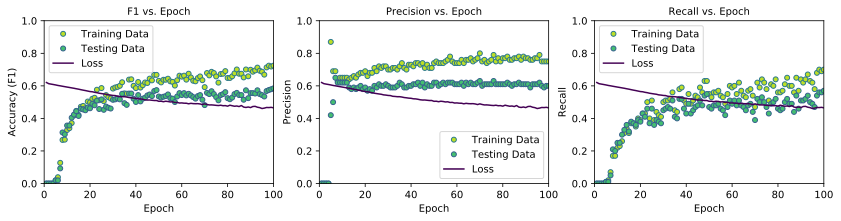

In [9]:
plot_model_training_results(*single_fold_results)

In [10]:
binary_measures(c_matrix,output=True);

F1 score:  0.58
Precision: 0.6
Recall:    0.57


#### Model Training: Train all Folds and Cross-Validate

In [11]:
# Train all of the folds and collate statistics and confusion matrix from all folds
fold_results_list = list()
confusion_matrix_list = list()
fold_count = 0

while True:
    try:
        train_ds = StockDataset.from_file(f'data/train-{fold_count}.npz')
        test_ds = StockDataset.from_file(f'data/test-{fold_count}.npz')
    except:
        break;
    
    print(f'Training fold {fold_count}')
    fold_results, c_matrix = train_and_validate_single_fold(train_ds,test_ds)
    
    fold_results_list.append(fold_results)
    confusion_matrix_list.append(c_matrix)
    fold_count += 1

Training fold 0
Epoch: 1/100, Loss: 0.6206, F1: 0, Precision: 0, Recall: 0.0
Epoch: 2/100, Loss: 0.6134, F1: 0, Precision: 0, Recall: 0.0
Epoch: 3/100, Loss: 0.6108, F1: 0, Precision: 0, Recall: 0.0
Epoch: 4/100, Loss: 0.6083, F1: 0, Precision: 0, Recall: 0.0
Epoch: 5/100, Loss: 0.6056, F1: 0.02, Precision: 0.87, Recall: 0.01
Epoch: 6/100, Loss: 0.6026, F1: 0.04, Precision: 0.69, Recall: 0.02
Epoch: 7/100, Loss: 0.6003, F1: 0.13, Precision: 0.69, Recall: 0.07
Epoch: 8/100, Loss: 0.5976, F1: 0.27, Precision: 0.63, Recall: 0.17
Epoch: 9/100, Loss: 0.5951, F1: 0.27, Precision: 0.65, Recall: 0.17
Epoch: 10/100, Loss: 0.5925, F1: 0.33, Precision: 0.65, Recall: 0.22
Epoch: 11/100, Loss: 0.5902, F1: 0.34, Precision: 0.65, Recall: 0.23
Epoch: 12/100, Loss: 0.5876, F1: 0.37, Precision: 0.65, Recall: 0.26
Epoch: 13/100, Loss: 0.5852, F1: 0.42, Precision: 0.64, Recall: 0.31
Epoch: 14/100, Loss: 0.5823, F1: 0.45, Precision: 0.65, Recall: 0.34
Epoch: 15/100, Loss: 0.5797, F1: 0.42, Precision: 0.66,

Fold  F1 Score  Precision  Recall
   0      0.58        0.6    0.57
   1      0.57       0.61    0.54
   2      0.56       0.63    0.51


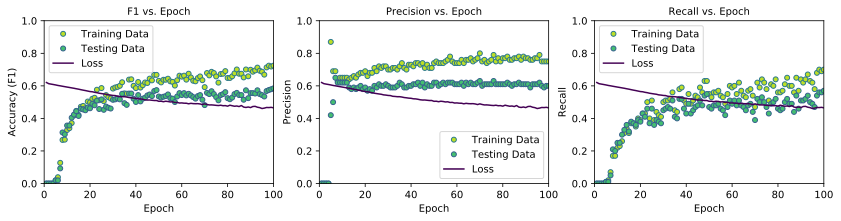

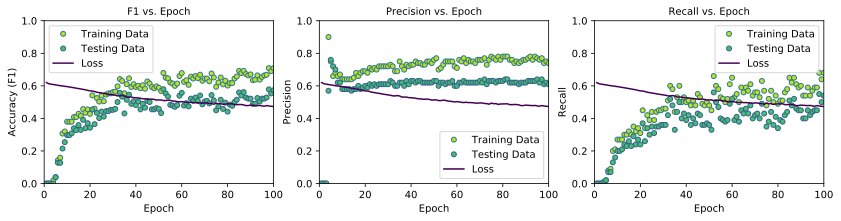

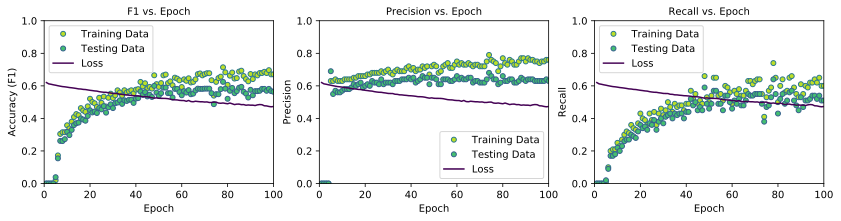

In [12]:
# Plot the results for each fold and inspect statistics
for i, fold_result in enumerate(fold_results_list):
    plot_model_training_results(*fold_result)

print('Fold  F1 Score  Precision  Recall')
for i, matrix in enumerate(confusion_matrix_list):
    a, p, r = binary_measures(matrix)
    print(f'%4s' % f'{i}' + f'%10s' % f'{round(a,2)}' + f'%11s' % f'{round(p,2)}' + f'%8s' % f'{round(r,2)}')

### Model Benchmark
We will now load the full dataset and see what kind of precision, recall and accuracy we would expect if we made decisions by tossing a coin. Since our dataset includes 12 offsets, this is an average over the last year; there may be seasonal variations in terms of precision and accuracy that we can look further into if interested.

In [13]:
train_full_ds = StockDataset.from_file('data/train-full.npz')

In [14]:
count_total = len(train_full_ds[:][1])
count_positive = train_full_ds[:][1].sum()
count_negative = count_total - count_positive
print(f'Number of samples: {count_total}')
print(f'Number of positive samples: {count_positive}')
print(f'Number of negative samples: {count_negative}')

Number of samples: 5826
Number of positive samples: 2711
Number of negative samples: 3115


In [15]:
# If we toss a coin and pick a stock, our precision and recall are
# as follows (this is the most naive of "models")
coin_p = 0.5
coin_toss_true_pos = coin_p*count_positive / count_total
coin_toss_true_neg = (1-coin_p)*count_negative / count_total
coin_toss_false_pos = coin_p*count_negative / count_total
coin_toss_false_neg = (1-coin_p)*count_positive / count_total

coin_toss_matrix = np.array([[coin_toss_true_pos,coin_toss_false_pos],[coin_toss_true_neg,coin_toss_false_neg]])

coin_toss_f1, coin_toss_precision, coin_toss_recall = binary_measures(coin_toss_matrix)
print(f'Coin toss F1:        {round(coin_toss_f1,2)}')
print(f'Coin toss precision: {round(coin_toss_precision,2)}')
print(f'Coin toss recall:    {round(coin_toss_recall,2)}')

Coin toss F1:        0.48
Coin toss precision: 0.47
Coin toss recall:    0.5


In [16]:
# We can also compare our model to historical analysts recommendations. 
# Historical analyst recommendations were scraped from the internet and
# only date back 2 quarters; comparisons are therefore limited in this regard
from model.benchmark import get_analyst_confusion_matrix_for_quarter

analyst_matrix_one = get_analyst_confusion_matrix_for_quarter(quarter_offset=1,output=False)
analyst_matrix_two = get_analyst_confusion_matrix_for_quarter(quarter_offset=2,output=False)
analyst_matrix = np.add(analyst_matrix_one,analyst_matrix_two)

print( '           %10s' % 'True' + '%10s' % 'False')
print(f'Positives: %10s' % f'{analyst_matrix[0][0]}' + '%10s' % f'{analyst_matrix[0][1]}')
print(f'Negatives: %10s' % f'{analyst_matrix[1][0]}' + '%10s' % f'{analyst_matrix[1][1]}')
print('')

binary_measures(analyst_matrix,output=True);

                 True     False
Positives:         94       135
Negatives:         21         6

F1 score:  0.57
Precision: 0.41
Recall:    0.94


In [17]:
# Combine confusion matrices across all folds to see how we compare to a coin-toss and analyst benchmarks
cumulative_matrix = np.zeros([2,2],dtype='int')
for matrix in confusion_matrix_list:
    cumulative_matrix = np.add(cumulative_matrix,matrix)

print( '           %10s' % 'True' + '%10s' % 'False')
print(f'Positives: %10s' % f'{cumulative_matrix[0][0]}' + '%10s' % f'{cumulative_matrix[0][1]}')
print(f'Negatives: %10s' % f'{cumulative_matrix[1][0]}' + '%10s' % f'{cumulative_matrix[1][1]}')
print('')

binary_measures(cumulative_matrix,output=True);

                 True     False
Positives:       1469       917
Negatives:       2198      1242

F1 score:  0.58
Precision: 0.62
Recall:    0.54


### Model Training: Final Model
Having now cross-validated the model, we will train the final model using *all* of the training data.

In [18]:
torch.manual_seed(42)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn   = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(np.array([0.8])))
train_dl  = torch.utils.data.DataLoader(train_full_ds, batch_size=300,shuffle=True,collate_fn = StockDataset.collate_data)

model     = StockClassifier(train_ds.get_prediction_interval(),
                            train_ds.get_data_interval(),
                            train_ds.get_categorical_feature_count(),
                            train_ds.get_categorical_feature_embedding_dims(),
                            train_ds.get_daily_feature_count(),
                            train_ds.get_quarterly_feature_count(),
                            embeddings_hidden_dim=10,
                            hidden_dim=500)

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
estimator = StockClassifierEstimator(model,optimizer,loss_fn,device)

In [19]:
estimator.fit(train_dl, epochs=100, output=True);

Epoch: 1, Loss: 0.617727530002594
Epoch: 2, Loss: 0.6112611144781113
Epoch: 3, Loss: 0.6084293037652969
Epoch: 4, Loss: 0.6056293994188309
Epoch: 5, Loss: 0.6023160934448242
Epoch: 6, Loss: 0.599285364151001
Epoch: 7, Loss: 0.5950583517551422
Epoch: 8, Loss: 0.5929939210414886
Epoch: 9, Loss: 0.5901900976896286
Epoch: 10, Loss: 0.5877386331558228
Epoch: 11, Loss: 0.583875298500061
Epoch: 12, Loss: 0.5820230841636658
Epoch: 13, Loss: 0.5790147423744202
Epoch: 14, Loss: 0.5746128767728805
Epoch: 15, Loss: 0.5733597666025162
Epoch: 16, Loss: 0.5714214742183685
Epoch: 17, Loss: 0.5676583886146546
Epoch: 18, Loss: 0.5666690051555634
Epoch: 19, Loss: 0.5611539214849472
Epoch: 20, Loss: 0.559359735250473
Epoch: 21, Loss: 0.5572911173105239
Epoch: 22, Loss: 0.554633030295372
Epoch: 23, Loss: 0.5531659573316574
Epoch: 24, Loss: 0.550723311305046
Epoch: 25, Loss: 0.5500970721244812
Epoch: 26, Loss: 0.5471415281295776
Epoch: 27, Loss: 0.5473725587129593
Epoch: 28, Loss: 0.5419301390647888
Epoch: 

In [20]:
# Save the trained model for later use (predictions)
model.to_file('data')